In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
import re
import math

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long).to(device)

In [29]:
with open('text.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    text = text[:50000]
    #убираем первый символ
    text = text.replace('\ufeff', '')
    text = text.replace('\n', ' ')
    text = text.replace('ё', 'е')
    # оставляем только символы кириллического алфавита
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"[^а-яА-Я\s]", "", text)
    text = text.lower()
words = text.split()


In [30]:
words[-10:]

['имел',
 'того',
 'хладнокровия',
 'которым',
 'хвалятся',
 'почти',
 'всегда',
 'те',
 'которые',
 'на']

In [31]:
# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(words)
vocab_size = len(vocab)
print(vocab_size)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

3255


In [32]:
word_to_ix

{'старинная': 0,
 'бродило': 1,
 'мошенник': 2,
 'болен': 3,
 'позвал': 4,
 'велел': 5,
 'примеривать': 6,
 'старичком': 7,
 'перевели': 8,
 'белы': 9,
 'поровнялись': 10,
 'походе': 11,
 'стариком': 12,
 'переписав': 13,
 'прошу': 14,
 'светлорусыми': 15,
 'самым': 16,
 'врать': 17,
 'волосы': 18,
 'малых': 19,
 'минуты': 20,
 'виноват': 21,
 'понимаю': 22,
 'изъезжена': 23,
 'прытость': 24,
 'внес': 25,
 'фремя': 26,
 'слабо': 27,
 'полтину': 28,
 'покрытых': 29,
 'спросить': 30,
 'подай': 31,
 'князь': 32,
 'дочь': 33,
 'симбирске': 34,
 'отвели': 35,
 'особенно': 36,
 'получал': 37,
 'гарнизонная': 38,
 'совершенными': 39,
 'охота': 40,
 'милостей': 41,
 'лишнего': 42,
 'гвардия': 43,
 'мундир': 44,
 'семену': 45,
 'вздор': 46,
 'рыло': 47,
 'начало': 48,
 'надел': 49,
 'каролинку': 50,
 'биллиарде': 51,
 'мигнул': 52,
 'опущенными': 53,
 'выигрыше': 54,
 'обстоятельства': 55,
 'малый': 56,
 'отставку': 57,
 'сержант': 58,
 'досадно': 59,
 'нетерпением': 60,
 'перебила': 61,
 'наро

In [33]:
data = []
for i in range(3, len(words)):
    context = [words[i - 3], words[i - 2], words[i - 1]]
    target = words[i]
    data.append((context, target))

In [34]:
data

[(['береги', 'честь', 'смолоду'], 'пословица'),
 (['честь', 'смолоду', 'пословица'], 'глава'),
 (['смолоду', 'пословица', 'глава'], 'сержант'),
 (['пословица', 'глава', 'сержант'], 'гвардии'),
 (['глава', 'сержант', 'гвардии'], 'гвардия'),
 (['сержант', 'гвардии', 'гвардия'], 'специальные'),
 (['гвардии', 'гвардия', 'специальные'], 'отборные'),
 (['гвардия', 'специальные', 'отборные'], 'войска'),
 (['специальные', 'отборные', 'войска'], 'первые'),
 (['отборные', 'войска', 'первые'], 'гвардейские'),
 (['войска', 'первые', 'гвардейские'], 'полки'),
 (['первые', 'гвардейские', 'полки'], 'семеновский'),
 (['гвардейские', 'полки', 'семеновский'], 'преображенский'),
 (['полки', 'семеновский', 'преображенский'], 'появились'),
 (['семеновский', 'преображенский', 'появились'], 'в'),
 (['преображенский', 'появились', 'в'], 'россии'),
 (['появились', 'в', 'россии'], 'при'),
 (['в', 'россии', 'при'], 'петре'),
 (['россии', 'при', 'петре'], 'в'),
 (['при', 'петре', 'в'], 'отличие'),
 (['петре', 'в'

In [35]:
x = []
y = []
for context, target in data:
    x.append([word_to_ix[word] for word in context])
    y.append(word_to_ix[target])

In [36]:
from sklearn.model_selection import train_test_split

x_t_v, x_test, y_t_v, y_test = train_test_split(x, y, test_size= 0.25, random_state=50)
x_train, x_val, y_train, y_val = train_test_split(x_t_v, y_t_v, test_size= 0.15, random_state=50)

In [37]:
len(x_train)

4924

In [38]:
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.long).to(device)
        self.labels = torch.tensor(labels, dtype=torch.long).to(device)

    def __len__(self):
        # Возвращаем количество элементов в датасете
        return len(self.features)

    def __getitem__(self, index):
        # Возвращаем элемент датасета по заданному индексу
        # Элемент датасета состоит из признаков и метки класса
        return self.features[index], self.labels[index]

In [39]:
batch_size = 150
embedding_dim = 128
hidden_dim = 256           
num_layers = 2                   
dropout_rate = 0.3                          

In [40]:
train_ds = MyDataset(x_train, y_train)
test_ds = MyDataset(x_test, y_test)
valid_ds = MyDataset(x_val, y_val)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, drop_last=True)

In [41]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, batch_size, device):    
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.device = device
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                    dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, src, hidden):
        embedding = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedding, hidden)          
        output = self.dropout(output) 
        prediction = self.fc(output)
        return prediction, hidden
    
    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hidden_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()
        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other) 
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim, 
                    self.hidden_dim).uniform_(-init_range_other, init_range_other) 

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden, cell
    
    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()
        return hidden, cell

In [42]:
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, batch_size, device)
model.to(device)
model

LSTM(
  (embedding): Embedding(3255, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3255, bias=True)
)

In [43]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 2,174,775 trainable parameters


In [44]:
def train(model, train_dataloader, optimizer, criterion, clip, batch_size, device):

    counter = 0
    epoch_loss = 0
    model.train()

    hidden = model.init_hidden(batch_size, device)
    
    for src, target in tqdm(train_dataloader, desc='Training: ',leave=False):
        counter += 1
        optimizer.zero_grad()
        hidden = model.detach_hidden(hidden)
        batch_size = src.shape[0]
        prediction, hidden = model(src, hidden)               
        prediction = prediction.reshape(batch_size, -1)   
        target = target.reshape(-1)
        loss = criterion(prediction, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / counter

In [45]:
def evaluate(model, validation_dataloader, criterion, batch_size, device):

    counter = 0
    epoch_loss = 0
    model.eval()

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for src, target in tqdm(validation_dataloader, desc='Validation: ',leave=False):
            counter += 1
            hidden = model.detach_hidden(hidden)
            batch_size= src.shape[0]
            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size, -1)
            target = target.reshape(-1)
            loss = criterion(prediction, target)
            epoch_loss += loss.item()
    if counter != 0:
        epoch_loss = epoch_loss / counter
    return epoch_loss

In [46]:
x, y = next(iter(train_dataloader))
hidden = model.init_hidden(batch_size, device)
hidden = model.detach_hidden(hidden)
hidden[0].shape
prediction, hidden = model(x, hidden)
prediction = prediction.reshape(batch_size, -1)
prediction.shape


torch.Size([150, 9765])

In [47]:
target = y.reshape(-1)
target.shape

torch.Size([150])

In [48]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
num_epochs = 150

In [49]:
n_epochs = 500
clip = 0.25
saved = False

train_loss = []
valid_loss = []
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

if saved:
    model.load_state_dict(torch.load('best-val-lstm_lm.pt',  map_location=device))
    test_loss = evaluate(model, validation_dataloader, loss_func, batch_size, device)
    print(f'Test Perplexity: {math.exp(test_loss):.3f}')
else:
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1} of {n_epochs}")
        train_epoch_loss = train(model, train_dataloader, optimizer, loss_func, clip, batch_size, device)
        valid_epoch_loss = evaluate(model, validation_dataloader, loss_func, batch_size, device)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        lr_scheduler.step(valid_epoch_loss)

        if valid_epoch_loss < best_valid_loss:
            best_valid_loss = valid_epoch_loss
            torch.save(model.state_dict(), 'best-val-lstm_lm.pt')

        print(f'Train loss: {(train_epoch_loss):.3f}')
        print(f'Valid loss: {(valid_epoch_loss):.3f}')
        print('-'*50)
        

Epoch 1 of 500


Train loss: 8.835
Valid loss: 8.476
--------------------------------------------------
Epoch 2 of 500


Train loss: 8.142
Valid loss: 8.680
--------------------------------------------------
Epoch 3 of 500


Train loss: 8.035
Valid loss: 8.724
--------------------------------------------------
Epoch 4 of 500


Train loss: 7.993
Valid loss: 8.876
--------------------------------------------------
Epoch 5 of 500


Train loss: 7.979
Valid loss: 8.855
--------------------------------------------------
Epoch 6 of 500


Train loss: 7.967
Valid loss: 8.866
--------------------------------------------------
Epoch 7 of 500


Train loss: 7.956
Valid loss: 8.861
--------------------------------------------------
Epoch 8 of 500


Train loss: 7.966
Valid loss: 8.871
--------------------------------------------------
Epoch 9 of 500


Train loss: 7.960
Valid loss: 8.853
--------------------------------------------------
Epoch 10 of 500


Train loss: 7.966
Valid loss: 8.912
--------------------------------------------------
Epoch 11 of 500


Train loss: 7.964
Valid loss: 8.827
--------------------------------------------------
Epoch 12 of 500


Train loss: 7.959
Valid loss: 8.876
--------------------------------------------------
Epoch 13 of 500


Train loss: 7.970
Valid loss: 8.882
--------------------------------------------------
Epoch 14 of 500


Train loss: 7.965
Valid loss: 8.845
--------------------------------------------------
Epoch 15 of 500


Train loss: 7.957
Valid loss: 8.803
--------------------------------------------------
Epoch 16 of 500


Train loss: 7.947
Valid loss: 8.845
--------------------------------------------------
Epoch 17 of 500


Train loss: 7.971
Valid loss: 8.841
--------------------------------------------------
Epoch 18 of 500


Train loss: 7.967
Valid loss: 8.916
--------------------------------------------------
Epoch 19 of 500


Train loss: 7.975
Valid loss: 8.826
--------------------------------------------------
Epoch 20 of 500


Train loss: 7.958
Valid loss: 8.902
--------------------------------------------------
Epoch 21 of 500


Train loss: 7.960
Valid loss: 8.836
--------------------------------------------------
Epoch 22 of 500


Train loss: 7.962
Valid loss: 8.856
--------------------------------------------------
Epoch 23 of 500


Train loss: 7.956
Valid loss: 8.849
--------------------------------------------------
Epoch 24 of 500


Train loss: 7.956
Valid loss: 8.803
--------------------------------------------------
Epoch 25 of 500


Train loss: 7.963
Valid loss: 8.769
--------------------------------------------------
Epoch 26 of 500


Train loss: 7.963
Valid loss: 8.967
--------------------------------------------------
Epoch 27 of 500


Train loss: 7.966
Valid loss: 8.913
--------------------------------------------------
Epoch 28 of 500


Train loss: 7.961
Valid loss: 8.843
--------------------------------------------------
Epoch 29 of 500


Train loss: 7.961
Valid loss: 8.765
--------------------------------------------------
Epoch 30 of 500


Train loss: 7.963
Valid loss: 8.828
--------------------------------------------------
Epoch 31 of 500


Train loss: 7.962
Valid loss: 8.828
--------------------------------------------------
Epoch 32 of 500


Train loss: 7.962
Valid loss: 8.847
--------------------------------------------------
Epoch 33 of 500


Train loss: 7.950
Valid loss: 8.877
--------------------------------------------------
Epoch 34 of 500


Train loss: 7.962
Valid loss: 8.877
--------------------------------------------------
Epoch 35 of 500


Train loss: 7.973
Valid loss: 8.930
--------------------------------------------------
Epoch 36 of 500


Train loss: 7.960
Valid loss: 8.868
--------------------------------------------------
Epoch 37 of 500


Train loss: 7.959
Valid loss: 8.868
--------------------------------------------------
Epoch 38 of 500


Train loss: 7.956
Valid loss: 8.873
--------------------------------------------------
Epoch 39 of 500


Train loss: 7.957
Valid loss: 8.812
--------------------------------------------------
Epoch 40 of 500


Train loss: 7.946
Valid loss: 8.860
--------------------------------------------------
Epoch 41 of 500


Train loss: 7.963
Valid loss: 8.788
--------------------------------------------------
Epoch 42 of 500


Train loss: 7.967
Valid loss: 8.956
--------------------------------------------------
Epoch 43 of 500


Train loss: 7.959
Valid loss: 8.872
--------------------------------------------------
Epoch 44 of 500


Train loss: 7.960
Valid loss: 8.835
--------------------------------------------------
Epoch 45 of 500


Train loss: 7.966
Valid loss: 8.891
--------------------------------------------------
Epoch 46 of 500


Train loss: 7.970
Valid loss: 8.895
--------------------------------------------------
Epoch 47 of 500


Train loss: 7.974
Valid loss: 8.858
--------------------------------------------------
Epoch 48 of 500


Train loss: 7.966
Valid loss: 8.850
--------------------------------------------------
Epoch 49 of 500


Train loss: 7.968
Valid loss: 8.869
--------------------------------------------------
Epoch 50 of 500


Train loss: 7.966
Valid loss: 8.911
--------------------------------------------------
Epoch 51 of 500


Train loss: 7.957
Valid loss: 8.879
--------------------------------------------------
Epoch 52 of 500


Train loss: 7.962
Valid loss: 8.906
--------------------------------------------------
Epoch 53 of 500


Train loss: 7.964
Valid loss: 8.839
--------------------------------------------------
Epoch 54 of 500


Train loss: 7.956
Valid loss: 8.819
--------------------------------------------------
Epoch 55 of 500


Train loss: 7.961
Valid loss: 8.857
--------------------------------------------------
Epoch 56 of 500


Train loss: 7.957
Valid loss: 8.796
--------------------------------------------------
Epoch 57 of 500


Train loss: 7.950
Valid loss: 8.875
--------------------------------------------------
Epoch 58 of 500


Train loss: 7.964
Valid loss: 8.900
--------------------------------------------------
Epoch 59 of 500


Train loss: 7.963
Valid loss: 8.846
--------------------------------------------------
Epoch 60 of 500


Train loss: 7.963
Valid loss: 8.867
--------------------------------------------------
Epoch 61 of 500


Train loss: 7.955
Valid loss: 8.841
--------------------------------------------------
Epoch 62 of 500


Train loss: 7.953
Valid loss: 8.907
--------------------------------------------------
Epoch 63 of 500


Train loss: 7.957
Valid loss: 8.837
--------------------------------------------------
Epoch 64 of 500


Train loss: 7.962
Valid loss: 8.875
--------------------------------------------------
Epoch 65 of 500


Train loss: 7.957
Valid loss: 8.867
--------------------------------------------------
Epoch 66 of 500


Train loss: 7.968
Valid loss: 8.865
--------------------------------------------------
Epoch 67 of 500


Train loss: 7.965
Valid loss: 8.834
--------------------------------------------------
Epoch 68 of 500


Train loss: 7.952
Valid loss: 8.817
--------------------------------------------------
Epoch 69 of 500


Train loss: 7.963
Valid loss: 8.912
--------------------------------------------------
Epoch 70 of 500


Train loss: 7.964
Valid loss: 8.847
--------------------------------------------------
Epoch 71 of 500


Train loss: 7.968
Valid loss: 8.861
--------------------------------------------------
Epoch 72 of 500


Train loss: 7.956
Valid loss: 8.790
--------------------------------------------------
Epoch 73 of 500


Train loss: 7.967
Valid loss: 8.980
--------------------------------------------------
Epoch 74 of 500


Train loss: 7.956
Valid loss: 8.857
--------------------------------------------------
Epoch 75 of 500


Train loss: 7.958
Valid loss: 8.859
--------------------------------------------------
Epoch 76 of 500


Train loss: 7.971
Valid loss: 8.918
--------------------------------------------------
Epoch 77 of 500


Train loss: 7.950
Valid loss: 8.916
--------------------------------------------------
Epoch 78 of 500


Train loss: 7.960
Valid loss: 8.843
--------------------------------------------------
Epoch 79 of 500


Train loss: 7.968
Valid loss: 8.883
--------------------------------------------------
Epoch 80 of 500


Train loss: 7.955
Valid loss: 8.876
--------------------------------------------------
Epoch 81 of 500


Train loss: 7.959
Valid loss: 8.830
--------------------------------------------------
Epoch 82 of 500


Train loss: 7.957
Valid loss: 8.808
--------------------------------------------------
Epoch 83 of 500


Train loss: 7.968
Valid loss: 8.916
--------------------------------------------------
Epoch 84 of 500


Train loss: 7.963
Valid loss: 8.839
--------------------------------------------------
Epoch 85 of 500


Train loss: 7.957
Valid loss: 8.877
--------------------------------------------------
Epoch 86 of 500


Train loss: 7.958
Valid loss: 8.784
--------------------------------------------------
Epoch 87 of 500


Train loss: 7.959
Valid loss: 8.855
--------------------------------------------------
Epoch 88 of 500


Train loss: 7.967
Valid loss: 8.903
--------------------------------------------------
Epoch 89 of 500


Train loss: 7.954
Valid loss: 8.864
--------------------------------------------------
Epoch 90 of 500


Train loss: 7.958
Valid loss: 8.829
--------------------------------------------------
Epoch 91 of 500


Train loss: 7.966
Valid loss: 8.874
--------------------------------------------------
Epoch 92 of 500


Train loss: 7.966
Valid loss: 8.854
--------------------------------------------------
Epoch 93 of 500


Train loss: 7.960
Valid loss: 8.918
--------------------------------------------------
Epoch 94 of 500


Train loss: 7.959
Valid loss: 8.859
--------------------------------------------------
Epoch 95 of 500


Train loss: 7.958
Valid loss: 8.845
--------------------------------------------------
Epoch 96 of 500


Train loss: 7.964
Valid loss: 8.855
--------------------------------------------------
Epoch 97 of 500


Train loss: 7.960
Valid loss: 8.890
--------------------------------------------------
Epoch 98 of 500


Train loss: 7.951
Valid loss: 8.841
--------------------------------------------------
Epoch 99 of 500


Train loss: 7.967
Valid loss: 8.885
--------------------------------------------------
Epoch 100 of 500


Train loss: 7.957
Valid loss: 8.881
--------------------------------------------------
Epoch 101 of 500


Train loss: 7.951
Valid loss: 8.878
--------------------------------------------------
Epoch 102 of 500


Train loss: 7.960
Valid loss: 8.842
--------------------------------------------------
Epoch 103 of 500


Train loss: 7.957
Valid loss: 8.874
--------------------------------------------------
Epoch 104 of 500


Train loss: 7.956
Valid loss: 8.911
--------------------------------------------------
Epoch 105 of 500


Train loss: 7.962
Valid loss: 8.818
--------------------------------------------------
Epoch 106 of 500


Train loss: 7.952
Valid loss: 8.831
--------------------------------------------------
Epoch 107 of 500


Train loss: 7.960
Valid loss: 8.874
--------------------------------------------------
Epoch 108 of 500


Train loss: 7.957
Valid loss: 8.852
--------------------------------------------------
Epoch 109 of 500


Train loss: 7.952
Valid loss: 8.801
--------------------------------------------------
Epoch 110 of 500


Train loss: 7.958
Valid loss: 8.898
--------------------------------------------------
Epoch 111 of 500


Train loss: 7.959
Valid loss: 8.858
--------------------------------------------------
Epoch 112 of 500


Train loss: 7.963
Valid loss: 8.908
--------------------------------------------------
Epoch 113 of 500


Train loss: 7.969
Valid loss: 8.920
--------------------------------------------------
Epoch 114 of 500


Train loss: 7.964
Valid loss: 8.934
--------------------------------------------------
Epoch 115 of 500


Train loss: 7.958
Valid loss: 8.902
--------------------------------------------------
Epoch 116 of 500


Train loss: 7.967
Valid loss: 8.877
--------------------------------------------------
Epoch 117 of 500


Train loss: 7.960
Valid loss: 8.818
--------------------------------------------------
Epoch 118 of 500


Train loss: 7.964
Valid loss: 8.917
--------------------------------------------------
Epoch 119 of 500


Train loss: 7.959
Valid loss: 8.833
--------------------------------------------------
Epoch 120 of 500


Train loss: 7.962
Valid loss: 8.890
--------------------------------------------------
Epoch 121 of 500


Train loss: 7.949
Valid loss: 8.895
--------------------------------------------------
Epoch 122 of 500


Train loss: 7.962
Valid loss: 8.862
--------------------------------------------------
Epoch 123 of 500


Train loss: 7.949
Valid loss: 8.885
--------------------------------------------------
Epoch 124 of 500


Train loss: 7.963
Valid loss: 8.879
--------------------------------------------------
Epoch 125 of 500


Train loss: 7.962
Valid loss: 8.875
--------------------------------------------------
Epoch 126 of 500


Train loss: 7.960
Valid loss: 8.850
--------------------------------------------------
Epoch 127 of 500


Train loss: 7.962
Valid loss: 8.856
--------------------------------------------------
Epoch 128 of 500


Train loss: 7.970
Valid loss: 8.805
--------------------------------------------------
Epoch 129 of 500


Train loss: 7.956
Valid loss: 8.855
--------------------------------------------------
Epoch 130 of 500


Train loss: 7.967
Valid loss: 8.822
--------------------------------------------------
Epoch 131 of 500


Train loss: 7.962
Valid loss: 8.841
--------------------------------------------------
Epoch 132 of 500


Train loss: 7.954
Valid loss: 8.892
--------------------------------------------------
Epoch 133 of 500


Train loss: 7.965
Valid loss: 8.882
--------------------------------------------------
Epoch 134 of 500


Train loss: 7.961
Valid loss: 8.890
--------------------------------------------------
Epoch 135 of 500


Train loss: 7.955
Valid loss: 8.857
--------------------------------------------------
Epoch 136 of 500


Train loss: 7.959
Valid loss: 8.931
--------------------------------------------------
Epoch 137 of 500


Train loss: 7.969
Valid loss: 8.814
--------------------------------------------------
Epoch 138 of 500


Train loss: 7.967
Valid loss: 8.909
--------------------------------------------------
Epoch 139 of 500


Train loss: 7.956
Valid loss: 8.883
--------------------------------------------------
Epoch 140 of 500


Train loss: 7.960
Valid loss: 8.874
--------------------------------------------------
Epoch 141 of 500


Train loss: 7.951
Valid loss: 8.863
--------------------------------------------------
Epoch 142 of 500


Train loss: 7.965
Valid loss: 8.905
--------------------------------------------------
Epoch 143 of 500


Train loss: 7.960
Valid loss: 8.898
--------------------------------------------------
Epoch 144 of 500


Train loss: 7.968
Valid loss: 8.875
--------------------------------------------------
Epoch 145 of 500


Train loss: 7.964
Valid loss: 8.825
--------------------------------------------------
Epoch 146 of 500


Train loss: 7.968
Valid loss: 8.898
--------------------------------------------------
Epoch 147 of 500


Train loss: 7.964
Valid loss: 8.853
--------------------------------------------------
Epoch 148 of 500


Train loss: 7.952
Valid loss: 8.907
--------------------------------------------------
Epoch 149 of 500


Train loss: 7.964
Valid loss: 8.832
--------------------------------------------------
Epoch 150 of 500


Train loss: 7.956
Valid loss: 8.848
--------------------------------------------------
Epoch 151 of 500


Train loss: 7.966
Valid loss: 8.842
--------------------------------------------------
Epoch 152 of 500


Train loss: 7.961
Valid loss: 8.840
--------------------------------------------------
Epoch 153 of 500


Train loss: 7.959
Valid loss: 8.937
--------------------------------------------------
Epoch 154 of 500


Train loss: 7.958
Valid loss: 8.939
--------------------------------------------------
Epoch 155 of 500


Train loss: 7.957
Valid loss: 8.798
--------------------------------------------------
Epoch 156 of 500


Train loss: 7.957
Valid loss: 8.839
--------------------------------------------------
Epoch 157 of 500


Train loss: 7.964
Valid loss: 8.926
--------------------------------------------------
Epoch 158 of 500


Train loss: 7.956
Valid loss: 8.906
--------------------------------------------------
Epoch 159 of 500


Train loss: 7.960
Valid loss: 8.924
--------------------------------------------------
Epoch 160 of 500


Train loss: 7.960
Valid loss: 8.794
--------------------------------------------------
Epoch 161 of 500


Train loss: 7.965
Valid loss: 8.936
--------------------------------------------------
Epoch 162 of 500


Train loss: 7.954
Valid loss: 8.894
--------------------------------------------------
Epoch 163 of 500


Train loss: 7.963
Valid loss: 8.925
--------------------------------------------------
Epoch 164 of 500


Train loss: 7.949
Valid loss: 8.803
--------------------------------------------------
Epoch 165 of 500


Train loss: 7.956
Valid loss: 8.827
--------------------------------------------------
Epoch 166 of 500


Train loss: 7.961
Valid loss: 8.815
--------------------------------------------------
Epoch 167 of 500


Train loss: 7.967
Valid loss: 8.850
--------------------------------------------------
Epoch 168 of 500


Train loss: 7.966
Valid loss: 8.835
--------------------------------------------------
Epoch 169 of 500


Train loss: 7.962
Valid loss: 8.855
--------------------------------------------------
Epoch 170 of 500


Train loss: 7.959
Valid loss: 8.821
--------------------------------------------------
Epoch 171 of 500


Train loss: 7.961
Valid loss: 8.870
--------------------------------------------------
Epoch 172 of 500


Train loss: 7.959
Valid loss: 8.839
--------------------------------------------------
Epoch 173 of 500


Train loss: 7.962
Valid loss: 8.939
--------------------------------------------------
Epoch 174 of 500


Train loss: 7.966
Valid loss: 8.916
--------------------------------------------------
Epoch 175 of 500


Train loss: 7.964
Valid loss: 8.862
--------------------------------------------------
Epoch 176 of 500


Train loss: 7.961
Valid loss: 8.866
--------------------------------------------------
Epoch 177 of 500


Train loss: 7.951
Valid loss: 8.908
--------------------------------------------------
Epoch 178 of 500


Train loss: 7.960
Valid loss: 8.834
--------------------------------------------------
Epoch 179 of 500


Train loss: 7.955
Valid loss: 8.876
--------------------------------------------------
Epoch 180 of 500


Train loss: 7.961
Valid loss: 8.845
--------------------------------------------------
Epoch 181 of 500


Train loss: 7.960
Valid loss: 8.929
--------------------------------------------------
Epoch 182 of 500


Train loss: 7.966
Valid loss: 8.858
--------------------------------------------------
Epoch 183 of 500


Train loss: 7.964
Valid loss: 8.849
--------------------------------------------------
Epoch 184 of 500


Train loss: 7.964
Valid loss: 8.825
--------------------------------------------------
Epoch 185 of 500


Train loss: 7.955
Valid loss: 8.874
--------------------------------------------------
Epoch 186 of 500


Train loss: 7.948
Valid loss: 8.908
--------------------------------------------------
Epoch 187 of 500


Train loss: 7.965
Valid loss: 8.875
--------------------------------------------------
Epoch 188 of 500


Train loss: 7.963
Valid loss: 8.908
--------------------------------------------------
Epoch 189 of 500


Train loss: 7.960
Valid loss: 8.852
--------------------------------------------------
Epoch 190 of 500


Train loss: 7.967
Valid loss: 8.892
--------------------------------------------------
Epoch 191 of 500


Train loss: 7.963
Valid loss: 8.858
--------------------------------------------------
Epoch 192 of 500


Train loss: 7.961
Valid loss: 8.804
--------------------------------------------------
Epoch 193 of 500


Train loss: 7.955
Valid loss: 8.903
--------------------------------------------------
Epoch 194 of 500


Train loss: 7.954
Valid loss: 8.778
--------------------------------------------------
Epoch 195 of 500


Train loss: 7.958
Valid loss: 8.776
--------------------------------------------------
Epoch 196 of 500


Train loss: 7.959
Valid loss: 8.900
--------------------------------------------------
Epoch 197 of 500


Train loss: 7.955
Valid loss: 8.888
--------------------------------------------------
Epoch 198 of 500


Train loss: 7.956
Valid loss: 8.865
--------------------------------------------------
Epoch 199 of 500


Train loss: 7.969
Valid loss: 8.913
--------------------------------------------------
Epoch 200 of 500


Train loss: 7.968
Valid loss: 8.892
--------------------------------------------------
Epoch 201 of 500


Train loss: 7.948
Valid loss: 8.878
--------------------------------------------------
Epoch 202 of 500


Train loss: 7.969
Valid loss: 8.879
--------------------------------------------------
Epoch 203 of 500


Train loss: 7.967
Valid loss: 8.865
--------------------------------------------------
Epoch 204 of 500


Train loss: 7.970
Valid loss: 8.874
--------------------------------------------------
Epoch 205 of 500


Train loss: 7.960
Valid loss: 8.881
--------------------------------------------------
Epoch 206 of 500


Train loss: 7.965
Valid loss: 8.928
--------------------------------------------------
Epoch 207 of 500


Train loss: 7.970
Valid loss: 8.909
--------------------------------------------------
Epoch 208 of 500


Train loss: 7.964
Valid loss: 8.905
--------------------------------------------------
Epoch 209 of 500


Train loss: 7.953
Valid loss: 8.780
--------------------------------------------------
Epoch 210 of 500


Train loss: 7.966
Valid loss: 8.926
--------------------------------------------------
Epoch 211 of 500


Train loss: 7.970
Valid loss: 8.899
--------------------------------------------------
Epoch 212 of 500


Train loss: 7.962
Valid loss: 8.865
--------------------------------------------------
Epoch 213 of 500


Train loss: 7.959
Valid loss: 8.847
--------------------------------------------------
Epoch 214 of 500


Train loss: 7.957
Valid loss: 8.857
--------------------------------------------------
Epoch 215 of 500


Train loss: 7.955
Valid loss: 8.907
--------------------------------------------------
Epoch 216 of 500


Train loss: 7.963
Valid loss: 8.867
--------------------------------------------------
Epoch 217 of 500


Train loss: 7.963
Valid loss: 8.822
--------------------------------------------------
Epoch 218 of 500


Train loss: 7.958
Valid loss: 8.910
--------------------------------------------------
Epoch 219 of 500


Train loss: 7.963
Valid loss: 8.828
--------------------------------------------------
Epoch 220 of 500


Train loss: 7.957
Valid loss: 8.899
--------------------------------------------------
Epoch 221 of 500


Train loss: 7.957
Valid loss: 8.890
--------------------------------------------------
Epoch 222 of 500


Train loss: 7.957
Valid loss: 8.892
--------------------------------------------------
Epoch 223 of 500


Train loss: 7.955
Valid loss: 8.889
--------------------------------------------------
Epoch 224 of 500


Train loss: 7.966
Valid loss: 8.862
--------------------------------------------------
Epoch 225 of 500


Train loss: 7.959
Valid loss: 8.912
--------------------------------------------------
Epoch 226 of 500


Train loss: 7.956
Valid loss: 8.832
--------------------------------------------------
Epoch 227 of 500


Train loss: 7.961
Valid loss: 8.897
--------------------------------------------------
Epoch 228 of 500


Train loss: 7.959
Valid loss: 8.913
--------------------------------------------------
Epoch 229 of 500


Train loss: 7.959
Valid loss: 8.893
--------------------------------------------------
Epoch 230 of 500


Train loss: 7.962
Valid loss: 8.877
--------------------------------------------------
Epoch 231 of 500


Train loss: 7.960
Valid loss: 8.786
--------------------------------------------------
Epoch 232 of 500


Train loss: 7.962
Valid loss: 8.863
--------------------------------------------------
Epoch 233 of 500


Train loss: 7.955
Valid loss: 8.833
--------------------------------------------------
Epoch 234 of 500


Train loss: 7.961
Valid loss: 8.923
--------------------------------------------------
Epoch 235 of 500


Train loss: 7.970
Valid loss: 8.889
--------------------------------------------------
Epoch 236 of 500


Train loss: 7.961
Valid loss: 8.828
--------------------------------------------------
Epoch 237 of 500


Train loss: 7.969
Valid loss: 8.897
--------------------------------------------------
Epoch 238 of 500


Train loss: 7.968
Valid loss: 8.790
--------------------------------------------------
Epoch 239 of 500


Train loss: 7.963
Valid loss: 8.837
--------------------------------------------------
Epoch 240 of 500


Train loss: 7.960
Valid loss: 8.911
--------------------------------------------------
Epoch 241 of 500


Train loss: 7.967
Valid loss: 8.979
--------------------------------------------------
Epoch 242 of 500


Train loss: 7.952
Valid loss: 8.924
--------------------------------------------------
Epoch 243 of 500


Train loss: 7.958
Valid loss: 8.917
--------------------------------------------------
Epoch 244 of 500


Train loss: 7.972
Valid loss: 8.834
--------------------------------------------------
Epoch 245 of 500


Train loss: 7.955
Valid loss: 8.819
--------------------------------------------------
Epoch 246 of 500


Train loss: 7.972
Valid loss: 8.875
--------------------------------------------------
Epoch 247 of 500


Train loss: 7.966
Valid loss: 8.879
--------------------------------------------------
Epoch 248 of 500


Train loss: 7.952
Valid loss: 8.894
--------------------------------------------------
Epoch 249 of 500


Train loss: 7.966
Valid loss: 8.900
--------------------------------------------------
Epoch 250 of 500


Train loss: 7.953
Valid loss: 8.876
--------------------------------------------------
Epoch 251 of 500


Train loss: 7.963
Valid loss: 8.882
--------------------------------------------------
Epoch 252 of 500


Train loss: 7.973
Valid loss: 8.877
--------------------------------------------------
Epoch 253 of 500


Train loss: 7.962
Valid loss: 8.871
--------------------------------------------------
Epoch 254 of 500


Train loss: 7.962
Valid loss: 8.843
--------------------------------------------------
Epoch 255 of 500


Train loss: 7.960
Valid loss: 8.962
--------------------------------------------------
Epoch 256 of 500


Train loss: 7.958
Valid loss: 8.860
--------------------------------------------------
Epoch 257 of 500


Train loss: 7.953
Valid loss: 8.935
--------------------------------------------------
Epoch 258 of 500


Train loss: 7.957
Valid loss: 8.843
--------------------------------------------------
Epoch 259 of 500


Train loss: 7.957
Valid loss: 8.846
--------------------------------------------------
Epoch 260 of 500


Train loss: 7.963
Valid loss: 8.862
--------------------------------------------------
Epoch 261 of 500


Train loss: 7.958
Valid loss: 8.830
--------------------------------------------------
Epoch 262 of 500


Train loss: 7.964
Valid loss: 8.888
--------------------------------------------------
Epoch 263 of 500


Train loss: 7.958
Valid loss: 8.831
--------------------------------------------------
Epoch 264 of 500


Train loss: 7.962
Valid loss: 8.908
--------------------------------------------------
Epoch 265 of 500


Train loss: 7.956
Valid loss: 8.946
--------------------------------------------------
Epoch 266 of 500


Train loss: 7.970
Valid loss: 8.848
--------------------------------------------------
Epoch 267 of 500


Train loss: 7.961
Valid loss: 8.887
--------------------------------------------------
Epoch 268 of 500


Train loss: 7.959
Valid loss: 8.938
--------------------------------------------------
Epoch 269 of 500


Train loss: 7.974
Valid loss: 8.844
--------------------------------------------------
Epoch 270 of 500


Train loss: 7.956
Valid loss: 8.874
--------------------------------------------------
Epoch 271 of 500


Train loss: 7.960
Valid loss: 8.890
--------------------------------------------------
Epoch 272 of 500


Train loss: 7.952
Valid loss: 8.863
--------------------------------------------------
Epoch 273 of 500


Train loss: 7.963
Valid loss: 8.879
--------------------------------------------------
Epoch 274 of 500


Train loss: 7.960
Valid loss: 8.902
--------------------------------------------------
Epoch 275 of 500


Train loss: 7.958
Valid loss: 8.833
--------------------------------------------------
Epoch 276 of 500


Train loss: 7.958
Valid loss: 8.898
--------------------------------------------------
Epoch 277 of 500


Train loss: 7.954
Valid loss: 8.826
--------------------------------------------------
Epoch 278 of 500


Train loss: 7.957
Valid loss: 8.860
--------------------------------------------------
Epoch 279 of 500


Train loss: 7.962
Valid loss: 8.887
--------------------------------------------------
Epoch 280 of 500


Train loss: 7.963
Valid loss: 8.886
--------------------------------------------------
Epoch 281 of 500


Train loss: 7.966
Valid loss: 8.846
--------------------------------------------------
Epoch 282 of 500


Train loss: 7.966
Valid loss: 8.813
--------------------------------------------------
Epoch 283 of 500


Train loss: 7.959
Valid loss: 8.925
--------------------------------------------------
Epoch 284 of 500


Train loss: 7.960
Valid loss: 8.855
--------------------------------------------------
Epoch 285 of 500


Train loss: 7.970
Valid loss: 8.948
--------------------------------------------------
Epoch 286 of 500


Train loss: 7.954
Valid loss: 8.875
--------------------------------------------------
Epoch 287 of 500


Train loss: 7.966
Valid loss: 8.805
--------------------------------------------------
Epoch 288 of 500


Train loss: 7.958
Valid loss: 8.817
--------------------------------------------------
Epoch 289 of 500


Train loss: 7.954
Valid loss: 8.832
--------------------------------------------------
Epoch 290 of 500


Train loss: 7.963
Valid loss: 8.820
--------------------------------------------------
Epoch 291 of 500


Train loss: 7.962
Valid loss: 8.872
--------------------------------------------------
Epoch 292 of 500


Train loss: 7.958
Valid loss: 8.774
--------------------------------------------------
Epoch 293 of 500


Train loss: 7.954
Valid loss: 8.799
--------------------------------------------------
Epoch 294 of 500


Train loss: 7.970
Valid loss: 8.837
--------------------------------------------------
Epoch 295 of 500


Train loss: 7.960
Valid loss: 8.962
--------------------------------------------------
Epoch 296 of 500


Train loss: 7.968
Valid loss: 8.901
--------------------------------------------------
Epoch 297 of 500


Train loss: 7.954
Valid loss: 8.813
--------------------------------------------------
Epoch 298 of 500


Train loss: 7.960
Valid loss: 8.849
--------------------------------------------------
Epoch 299 of 500


Train loss: 7.957
Valid loss: 8.840
--------------------------------------------------
Epoch 300 of 500


Train loss: 7.960
Valid loss: 8.877
--------------------------------------------------
Epoch 301 of 500


Train loss: 7.969
Valid loss: 8.885
--------------------------------------------------
Epoch 302 of 500


Train loss: 7.966
Valid loss: 8.894
--------------------------------------------------
Epoch 303 of 500


Train loss: 7.963
Valid loss: 8.887
--------------------------------------------------
Epoch 304 of 500


Train loss: 7.955
Valid loss: 8.866
--------------------------------------------------
Epoch 305 of 500


Train loss: 7.963
Valid loss: 8.929
--------------------------------------------------
Epoch 306 of 500


Train loss: 7.960
Valid loss: 8.913
--------------------------------------------------
Epoch 307 of 500


Train loss: 7.960
Valid loss: 8.896
--------------------------------------------------
Epoch 308 of 500


Train loss: 7.963
Valid loss: 8.895
--------------------------------------------------
Epoch 309 of 500


Train loss: 7.962
Valid loss: 8.873
--------------------------------------------------
Epoch 310 of 500


Train loss: 7.958
Valid loss: 8.800
--------------------------------------------------
Epoch 311 of 500


Train loss: 7.957
Valid loss: 8.866
--------------------------------------------------
Epoch 312 of 500


Train loss: 7.967
Valid loss: 8.842
--------------------------------------------------
Epoch 313 of 500


Train loss: 7.956
Valid loss: 8.904
--------------------------------------------------
Epoch 314 of 500


Train loss: 7.969
Valid loss: 8.861
--------------------------------------------------
Epoch 315 of 500


Train loss: 7.955
Valid loss: 8.892
--------------------------------------------------
Epoch 316 of 500


Train loss: 7.966
Valid loss: 8.873
--------------------------------------------------
Epoch 317 of 500


Train loss: 7.956
Valid loss: 8.918
--------------------------------------------------
Epoch 318 of 500


Train loss: 7.953
Valid loss: 8.896
--------------------------------------------------
Epoch 319 of 500


Train loss: 7.961
Valid loss: 8.824
--------------------------------------------------
Epoch 320 of 500


Train loss: 7.959
Valid loss: 8.869
--------------------------------------------------
Epoch 321 of 500


Train loss: 7.962
Valid loss: 8.828
--------------------------------------------------
Epoch 322 of 500


Train loss: 7.961
Valid loss: 8.941
--------------------------------------------------
Epoch 323 of 500


Train loss: 7.957
Valid loss: 8.886
--------------------------------------------------
Epoch 324 of 500


Train loss: 7.959
Valid loss: 8.830
--------------------------------------------------
Epoch 325 of 500


Train loss: 7.967
Valid loss: 8.924
--------------------------------------------------
Epoch 326 of 500


Train loss: 7.962
Valid loss: 8.853
--------------------------------------------------
Epoch 327 of 500


Train loss: 7.954
Valid loss: 8.853
--------------------------------------------------
Epoch 328 of 500


Train loss: 7.961
Valid loss: 8.898
--------------------------------------------------
Epoch 329 of 500


Train loss: 7.953
Valid loss: 8.916
--------------------------------------------------
Epoch 330 of 500


Train loss: 7.968
Valid loss: 8.857
--------------------------------------------------
Epoch 331 of 500


Train loss: 7.960
Valid loss: 8.835
--------------------------------------------------
Epoch 332 of 500


Train loss: 7.971
Valid loss: 8.893
--------------------------------------------------
Epoch 333 of 500


Train loss: 7.957
Valid loss: 8.811
--------------------------------------------------
Epoch 334 of 500


Train loss: 7.953
Valid loss: 8.848
--------------------------------------------------
Epoch 335 of 500


Train loss: 7.960
Valid loss: 8.882
--------------------------------------------------
Epoch 336 of 500


Train loss: 7.963
Valid loss: 8.867
--------------------------------------------------
Epoch 337 of 500


Train loss: 7.955
Valid loss: 8.905
--------------------------------------------------
Epoch 338 of 500


Train loss: 7.948
Valid loss: 8.791
--------------------------------------------------
Epoch 339 of 500


Train loss: 7.951
Valid loss: 8.910
--------------------------------------------------
Epoch 340 of 500


Train loss: 7.970
Valid loss: 8.872
--------------------------------------------------
Epoch 341 of 500


Train loss: 7.964
Valid loss: 8.763
--------------------------------------------------
Epoch 342 of 500


Train loss: 7.962
Valid loss: 8.795
--------------------------------------------------
Epoch 343 of 500


Train loss: 7.960
Valid loss: 8.879
--------------------------------------------------
Epoch 344 of 500


Train loss: 7.963
Valid loss: 8.831
--------------------------------------------------
Epoch 345 of 500


Train loss: 7.954
Valid loss: 8.889
--------------------------------------------------
Epoch 346 of 500


Train loss: 7.959
Valid loss: 8.890
--------------------------------------------------
Epoch 347 of 500


Train loss: 7.956
Valid loss: 8.893
--------------------------------------------------
Epoch 348 of 500


Train loss: 7.959
Valid loss: 8.814
--------------------------------------------------
Epoch 349 of 500


Train loss: 7.952
Valid loss: 8.846
--------------------------------------------------
Epoch 350 of 500


Train loss: 7.965
Valid loss: 8.875
--------------------------------------------------
Epoch 351 of 500


Train loss: 7.959
Valid loss: 8.844
--------------------------------------------------
Epoch 352 of 500


Train loss: 7.961
Valid loss: 8.881
--------------------------------------------------
Epoch 353 of 500


Train loss: 7.967
Valid loss: 8.811
--------------------------------------------------
Epoch 354 of 500


Train loss: 7.966
Valid loss: 8.865
--------------------------------------------------
Epoch 355 of 500


Train loss: 7.950
Valid loss: 8.870
--------------------------------------------------
Epoch 356 of 500


Train loss: 7.964
Valid loss: 8.867
--------------------------------------------------
Epoch 357 of 500


Train loss: 7.958
Valid loss: 8.800
--------------------------------------------------
Epoch 358 of 500


Train loss: 7.961
Valid loss: 8.880
--------------------------------------------------
Epoch 359 of 500


Train loss: 7.957
Valid loss: 8.873
--------------------------------------------------
Epoch 360 of 500


Train loss: 7.966
Valid loss: 8.851
--------------------------------------------------
Epoch 361 of 500


Train loss: 7.954
Valid loss: 8.979
--------------------------------------------------
Epoch 362 of 500


Train loss: 7.955
Valid loss: 8.852
--------------------------------------------------
Epoch 363 of 500


Train loss: 7.958
Valid loss: 8.937
--------------------------------------------------
Epoch 364 of 500


Train loss: 7.966
Valid loss: 8.862
--------------------------------------------------
Epoch 365 of 500


Train loss: 7.968
Valid loss: 8.872
--------------------------------------------------
Epoch 366 of 500


Train loss: 7.955
Valid loss: 8.842
--------------------------------------------------
Epoch 367 of 500


Train loss: 7.957
Valid loss: 8.847
--------------------------------------------------
Epoch 368 of 500


Train loss: 7.956
Valid loss: 8.835
--------------------------------------------------
Epoch 369 of 500


Train loss: 7.962
Valid loss: 8.894
--------------------------------------------------
Epoch 370 of 500


Train loss: 7.962
Valid loss: 8.890
--------------------------------------------------
Epoch 371 of 500


Train loss: 7.955
Valid loss: 8.895
--------------------------------------------------
Epoch 372 of 500


Train loss: 7.961
Valid loss: 8.855
--------------------------------------------------
Epoch 373 of 500


Train loss: 7.956
Valid loss: 8.832
--------------------------------------------------
Epoch 374 of 500


Train loss: 7.970
Valid loss: 8.882
--------------------------------------------------
Epoch 375 of 500


Train loss: 7.974
Valid loss: 8.931
--------------------------------------------------
Epoch 376 of 500


Train loss: 7.968
Valid loss: 8.866
--------------------------------------------------
Epoch 377 of 500


Train loss: 7.960
Valid loss: 8.830
--------------------------------------------------
Epoch 378 of 500


Train loss: 7.953
Valid loss: 8.913
--------------------------------------------------
Epoch 379 of 500


Train loss: 7.963
Valid loss: 8.875
--------------------------------------------------
Epoch 380 of 500


Train loss: 7.965
Valid loss: 8.787
--------------------------------------------------
Epoch 381 of 500


Train loss: 7.960
Valid loss: 8.853
--------------------------------------------------
Epoch 382 of 500


Train loss: 7.965
Valid loss: 8.819
--------------------------------------------------
Epoch 383 of 500


Train loss: 7.966
Valid loss: 8.887
--------------------------------------------------
Epoch 384 of 500


Train loss: 7.959
Valid loss: 8.910
--------------------------------------------------
Epoch 385 of 500


Train loss: 7.968
Valid loss: 8.868
--------------------------------------------------
Epoch 386 of 500


Train loss: 7.959
Valid loss: 8.850
--------------------------------------------------
Epoch 387 of 500


Train loss: 7.964
Valid loss: 8.931
--------------------------------------------------
Epoch 388 of 500


Train loss: 7.949
Valid loss: 8.825
--------------------------------------------------
Epoch 389 of 500


Train loss: 7.963
Valid loss: 8.866
--------------------------------------------------
Epoch 390 of 500


Train loss: 7.957
Valid loss: 8.961
--------------------------------------------------
Epoch 391 of 500


Train loss: 7.957
Valid loss: 8.825
--------------------------------------------------
Epoch 392 of 500


Train loss: 7.963
Valid loss: 8.916
--------------------------------------------------
Epoch 393 of 500


Train loss: 7.963
Valid loss: 8.835
--------------------------------------------------
Epoch 394 of 500


Train loss: 7.955
Valid loss: 8.858
--------------------------------------------------
Epoch 395 of 500


Train loss: 7.959
Valid loss: 8.927
--------------------------------------------------
Epoch 396 of 500


Train loss: 7.952
Valid loss: 8.891
--------------------------------------------------
Epoch 397 of 500


Train loss: 7.953
Valid loss: 8.931
--------------------------------------------------
Epoch 398 of 500


Train loss: 7.957
Valid loss: 8.879
--------------------------------------------------
Epoch 399 of 500


Train loss: 7.957
Valid loss: 8.848
--------------------------------------------------
Epoch 400 of 500


Train loss: 7.961
Valid loss: 8.862
--------------------------------------------------
Epoch 401 of 500


Train loss: 7.962
Valid loss: 8.917
--------------------------------------------------
Epoch 402 of 500


Train loss: 7.963
Valid loss: 8.929
--------------------------------------------------
Epoch 403 of 500


Train loss: 7.961
Valid loss: 8.907
--------------------------------------------------
Epoch 404 of 500


Train loss: 7.963
Valid loss: 8.880
--------------------------------------------------
Epoch 405 of 500


Train loss: 7.962
Valid loss: 8.877
--------------------------------------------------
Epoch 406 of 500


Train loss: 7.962
Valid loss: 8.888
--------------------------------------------------
Epoch 407 of 500


Train loss: 7.960
Valid loss: 8.862
--------------------------------------------------
Epoch 408 of 500


Train loss: 7.955
Valid loss: 8.894
--------------------------------------------------
Epoch 409 of 500


Train loss: 7.966
Valid loss: 8.847
--------------------------------------------------
Epoch 410 of 500


Train loss: 7.956
Valid loss: 8.829
--------------------------------------------------
Epoch 411 of 500


Train loss: 7.957
Valid loss: 8.783
--------------------------------------------------
Epoch 412 of 500


Train loss: 7.968
Valid loss: 8.883
--------------------------------------------------
Epoch 413 of 500


Train loss: 7.956
Valid loss: 8.894
--------------------------------------------------
Epoch 414 of 500


Train loss: 7.963
Valid loss: 8.895
--------------------------------------------------
Epoch 415 of 500


Train loss: 7.963
Valid loss: 8.775
--------------------------------------------------
Epoch 416 of 500


Train loss: 7.963
Valid loss: 8.857
--------------------------------------------------
Epoch 417 of 500


Train loss: 7.953
Valid loss: 8.819
--------------------------------------------------
Epoch 418 of 500


Train loss: 7.958
Valid loss: 8.854
--------------------------------------------------
Epoch 419 of 500


Train loss: 7.962
Valid loss: 8.823
--------------------------------------------------
Epoch 420 of 500


Train loss: 7.968
Valid loss: 8.824
--------------------------------------------------
Epoch 421 of 500


Train loss: 7.972
Valid loss: 8.817
--------------------------------------------------
Epoch 422 of 500


Train loss: 7.963
Valid loss: 8.779
--------------------------------------------------
Epoch 423 of 500


Train loss: 7.957
Valid loss: 8.865
--------------------------------------------------
Epoch 424 of 500


Train loss: 7.968
Valid loss: 8.763
--------------------------------------------------
Epoch 425 of 500


Train loss: 7.966
Valid loss: 8.838
--------------------------------------------------
Epoch 426 of 500


Train loss: 7.961
Valid loss: 8.853
--------------------------------------------------
Epoch 427 of 500


Train loss: 7.960
Valid loss: 8.906
--------------------------------------------------
Epoch 428 of 500


Train loss: 7.960
Valid loss: 8.862
--------------------------------------------------
Epoch 429 of 500


Train loss: 7.966
Valid loss: 8.924
--------------------------------------------------
Epoch 430 of 500


Train loss: 7.963
Valid loss: 8.916
--------------------------------------------------
Epoch 431 of 500


Train loss: 7.959
Valid loss: 8.832
--------------------------------------------------
Epoch 432 of 500


Train loss: 7.961
Valid loss: 8.879
--------------------------------------------------
Epoch 433 of 500


Train loss: 7.958
Valid loss: 8.953
--------------------------------------------------
Epoch 434 of 500


Train loss: 7.963
Valid loss: 8.833
--------------------------------------------------
Epoch 435 of 500


Train loss: 7.967
Valid loss: 8.919
--------------------------------------------------
Epoch 436 of 500


Train loss: 7.966
Valid loss: 8.857
--------------------------------------------------
Epoch 437 of 500


Train loss: 7.958
Valid loss: 8.834
--------------------------------------------------
Epoch 438 of 500


Train loss: 7.952
Valid loss: 8.799
--------------------------------------------------
Epoch 439 of 500


Train loss: 7.957
Valid loss: 8.893
--------------------------------------------------
Epoch 440 of 500


Train loss: 7.967
Valid loss: 8.910
--------------------------------------------------
Epoch 441 of 500


Train loss: 7.976
Valid loss: 8.914
--------------------------------------------------
Epoch 442 of 500


Train loss: 7.959
Valid loss: 8.928
--------------------------------------------------
Epoch 443 of 500


Train loss: 7.963
Valid loss: 8.920
--------------------------------------------------
Epoch 444 of 500


Train loss: 7.965
Valid loss: 8.824
--------------------------------------------------
Epoch 445 of 500


Train loss: 7.955
Valid loss: 8.832
--------------------------------------------------
Epoch 446 of 500


Train loss: 7.958
Valid loss: 8.840
--------------------------------------------------
Epoch 447 of 500


Train loss: 7.970
Valid loss: 8.844
--------------------------------------------------
Epoch 448 of 500


Train loss: 7.967
Valid loss: 8.850
--------------------------------------------------
Epoch 449 of 500


Train loss: 7.966
Valid loss: 8.843
--------------------------------------------------
Epoch 450 of 500


Train loss: 7.965
Valid loss: 8.924
--------------------------------------------------
Epoch 451 of 500


Train loss: 7.966
Valid loss: 8.795
--------------------------------------------------
Epoch 452 of 500


Train loss: 7.959
Valid loss: 8.833
--------------------------------------------------
Epoch 453 of 500


Train loss: 7.963
Valid loss: 8.901
--------------------------------------------------
Epoch 454 of 500


Train loss: 7.946
Valid loss: 8.836
--------------------------------------------------
Epoch 455 of 500


Train loss: 7.963
Valid loss: 8.898
--------------------------------------------------
Epoch 456 of 500


Train loss: 7.960
Valid loss: 8.930
--------------------------------------------------
Epoch 457 of 500


Train loss: 7.956
Valid loss: 8.854
--------------------------------------------------
Epoch 458 of 500


Train loss: 7.969
Valid loss: 8.806
--------------------------------------------------
Epoch 459 of 500


Train loss: 7.964
Valid loss: 8.892
--------------------------------------------------
Epoch 460 of 500


Train loss: 7.963
Valid loss: 8.812
--------------------------------------------------
Epoch 461 of 500


Train loss: 7.962
Valid loss: 8.813
--------------------------------------------------
Epoch 462 of 500


Train loss: 7.957
Valid loss: 8.871
--------------------------------------------------
Epoch 463 of 500


Train loss: 7.960
Valid loss: 8.925
--------------------------------------------------
Epoch 464 of 500


Train loss: 7.959
Valid loss: 8.840
--------------------------------------------------
Epoch 465 of 500


Train loss: 7.964
Valid loss: 8.847
--------------------------------------------------
Epoch 466 of 500


Train loss: 7.962
Valid loss: 8.868
--------------------------------------------------
Epoch 467 of 500


Train loss: 7.965
Valid loss: 8.837
--------------------------------------------------
Epoch 468 of 500


Train loss: 7.966
Valid loss: 8.900
--------------------------------------------------
Epoch 469 of 500


Train loss: 7.954
Valid loss: 8.868
--------------------------------------------------
Epoch 470 of 500


Train loss: 7.962
Valid loss: 8.803
--------------------------------------------------
Epoch 471 of 500


Train loss: 7.956
Valid loss: 8.954
--------------------------------------------------
Epoch 472 of 500


Train loss: 7.964
Valid loss: 8.849
--------------------------------------------------
Epoch 473 of 500


Train loss: 7.954
Valid loss: 8.875
--------------------------------------------------
Epoch 474 of 500


Train loss: 7.953
Valid loss: 8.816
--------------------------------------------------
Epoch 475 of 500


Train loss: 7.958
Valid loss: 8.804
--------------------------------------------------
Epoch 476 of 500


Train loss: 7.961
Valid loss: 8.959
--------------------------------------------------
Epoch 477 of 500


Train loss: 7.967
Valid loss: 8.871
--------------------------------------------------
Epoch 478 of 500


Train loss: 7.963
Valid loss: 8.885
--------------------------------------------------
Epoch 479 of 500


Train loss: 7.950
Valid loss: 8.888
--------------------------------------------------
Epoch 480 of 500


Train loss: 7.954
Valid loss: 8.855
--------------------------------------------------
Epoch 481 of 500


Train loss: 7.962
Valid loss: 8.885
--------------------------------------------------
Epoch 482 of 500


Train loss: 7.970
Valid loss: 8.854
--------------------------------------------------
Epoch 483 of 500


Train loss: 7.957
Valid loss: 8.840
--------------------------------------------------
Epoch 484 of 500


Train loss: 7.968
Valid loss: 8.906
--------------------------------------------------
Epoch 485 of 500


Train loss: 7.968
Valid loss: 8.948
--------------------------------------------------
Epoch 486 of 500


Train loss: 7.962
Valid loss: 8.840
--------------------------------------------------
Epoch 487 of 500


Train loss: 7.968
Valid loss: 8.893
--------------------------------------------------
Epoch 488 of 500


Train loss: 7.960
Valid loss: 8.817
--------------------------------------------------
Epoch 489 of 500


Train loss: 7.962
Valid loss: 8.907
--------------------------------------------------
Epoch 490 of 500


Train loss: 7.963
Valid loss: 8.887
--------------------------------------------------
Epoch 491 of 500


Train loss: 7.957
Valid loss: 8.873
--------------------------------------------------
Epoch 492 of 500


Train loss: 7.959
Valid loss: 8.918
--------------------------------------------------
Epoch 493 of 500


Train loss: 7.970
Valid loss: 8.900
--------------------------------------------------
Epoch 494 of 500


Train loss: 7.967
Valid loss: 8.877
--------------------------------------------------
Epoch 495 of 500


Train loss: 7.964
Valid loss: 8.830
--------------------------------------------------
Epoch 496 of 500


Train loss: 7.970
Valid loss: 8.852
--------------------------------------------------
Epoch 497 of 500


Train loss: 7.955
Valid loss: 8.836
--------------------------------------------------
Epoch 498 of 500


Train loss: 7.960
Valid loss: 8.894
--------------------------------------------------
Epoch 499 of 500


Train loss: 7.959
Valid loss: 8.946
--------------------------------------------------
Epoch 500 of 500


Train loss: 7.949
Valid loss: 8.807
--------------------------------------------------


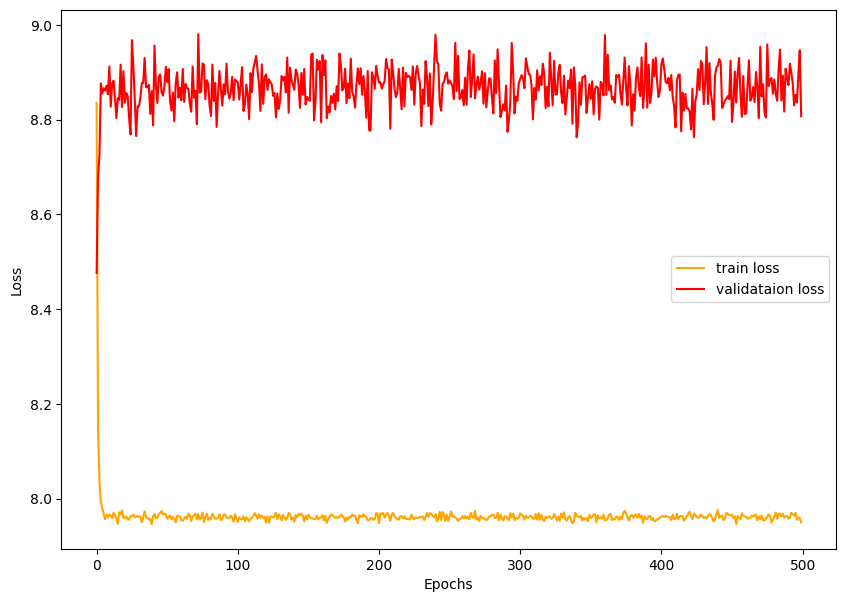

In [50]:
import matplotlib.pyplot as plt
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss')
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
ix_to_word.__len__()

3255

In [85]:
src, target =  next(iter(test_dataloader))
hidden = model.detach_hidden(hidden)
batch_size= src.shape[0]
prediction, hidden = model(src, hidden)
prediction = prediction[0].reshape(-1)
target = target.reshape(-1)

predicted_ix = torch.argmax(prediction).item()
predicted_ix
# predicted_word = ix_to_word[predicted_ix]
# predicted_word
# words = src.view(-1).cpu().detach().numpy()

# print(f'Context: {[ix_to_word[word] for word in words]}\n')
# print(f'Prediction: {predicted_word}\n')

1349

In [53]:
context, target = next(iter(test_dataloader))
context = context[0].view(1, -1)
target = target[0]
output = model(context).cpu()
predicted_ix = torch.argmax(output).item()
predicted_word = ix_to_word[predicted_ix]
words = context.view(-1).cpu().detach().numpy()

print(f'Context: {[ix_to_word[word] for word in words]}\n')
print(f'Prediction: {predicted_word}\n')

TypeError: LSTM.forward() missing 1 required positional argument: 'hidden'

In [ ]:
# Определяем функцию для вычисления косинусного сходства между двумя векторами
def cosine_similarity(v1, v2):
    dot_product = torch.dot(v1, v2)
    norm_v1 = torch.norm(v1)
    norm_v2 = torch.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

# Определяем функцию для поиска наиболее похожих слов на заданное слово
def find_similar_words(word, word_vectors, idx2word, top_k=5):
    word_idx = word_to_ix[word]
    word_vector = word_vectors[word_idx]
    similarities = []
    for i, vector in enumerate(word_vectors):
        if i == word_idx:
            continue
        similarity = cosine_similarity(word_vector, vector)
        similarities.append((i, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)
    similar_words = [idx2word[i] for i, _ in similarities[:top_k]]
    return similar_words

# Пробуем найти похожие слова на слово "война"
similar_words = find_similar_words("силы", word_embeddings, ix_to_word)
print(f"Слова, похожие на слово 'силы': {', '.join(similar_words)}")

Слова, похожие на слово 'силы': пышную, доходишками, униженными, сына, сараи
